In [1]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
#!pip install tensorflow==2.0.0-beta0

tf.enable_eager_execution()

# !pip install -q tensorflow-datasets

C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

1.14.0


C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:5

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print("")
print(training_sentences[1])

b this was soul provoking i am an iranian and living in <OOV> 21st century i didn't know that such big <OOV> have been living in such conditions at the time of my grandfather br br you see that today or even in <OOV> on one side of the world a lady or a baby could have everything served for him or her clean and on demand but here 80 years ago people <OOV> their life to go to somewhere with more grass it's really interesting that these <OOV> bear those difficulties to find <OOV> for their sheep but they lose many the sheep on their way br br i praise the americans who accompanied this tribe they were as

b"This was soul-provoking! I am an Iranian, and living in th 21st century, I didn't know that such big tribes have been living in such conditions at the time of my grandfather!<br /><br />You see that today, or even in 1925, on one side of the world a lady or a baby could have everything served for him or her clean and on-demand, but here 80 years ago, people ventured their life to go t

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


## save weights

In [7]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), verbose=2, callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10

Epoch 00001: saving model to training_1/cp.ckpt
25000/25000 - 4s - loss: 0.4947 - acc: 0.7412 - val_loss: 0.3547 - val_acc: 0.8432
Epoch 2/10

Epoch 00002: saving model to training_1/cp.ckpt
25000/25000 - 3s - loss: 0.2345 - acc: 0.9091 - val_loss: 0.3800 - val_acc: 0.8342
Epoch 3/10

Epoch 00003: saving model to training_1/cp.ckpt
25000/25000 - 3s - loss: 0.0808 - acc: 0.9803 - val_loss: 0.4540 - val_acc: 0.8260
Epoch 4/10

Epoch 00004: saving model to training_1/cp.ckpt
25000/25000 - 3s - loss: 0.0174 - acc: 0.9982 - val_loss: 0.5371 - val_acc: 0.8258
Epoch 5/10

Epoch 00005: saving model to training_1/cp.ckpt
25000/25000 - 3s - loss: 0.0040 - acc: 0.9998 - val_loss: 0.5904 - val_acc: 0.8264
Epoch 6/10

Epoch 00006: saving model to training_1/cp.ckpt
25000/25000 - 3s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.6369 - val_acc: 0.8274
Epoch 7/10

Epoch 00007: saving model to training_1/cp.ckpt
25000/25000 - 3s - loss: 7.6746e-04 - acc: 1.0000 - val_loss: 0.6781 - val_acc: 0.

In [8]:
# make the same model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss,acc = model.evaluate(testing_padded, testing_labels_final, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

25000/25000 - 1s - loss: 0.7863 - acc: 0.8281
Restored model, accuracy: 82.81%


In [9]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


## plot

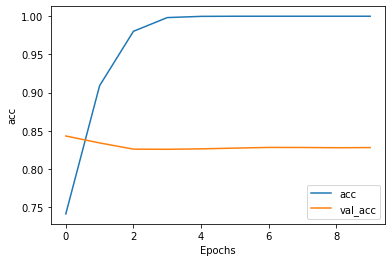

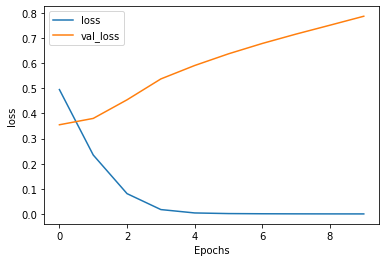

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Test new case

In [11]:
sentences = ['I really think this is amazing. honest.',
             "it's wasting time.",
             'the best of this year!',
             'yearly junk',
             'read the book, instead of going to cinema',
             'your kids will love it!',
             'the effect is cheap.']
sequence = tokenizer.texts_to_sequences(sentences)
print(sequence)
r = model.predict(pad_sequences(sequence, maxlen = max_length, padding = 'post', truncating = trunc_type))
for u, v in list(zip(sentences, r)):
    rating = 'Good' if v[0] > 0.5 else 'Bad'
    print(f'{u} → {rating}')

[[11, 68, 105, 12, 7, 490, 1216], [103, 3156, 60], [2, 120, 5, 12, 281], [1, 2616], [337, 2, 274, 306, 5, 168, 6, 436], [131, 357, 81, 119, 10], [2, 970, 7, 716]]
I really think this is amazing. honest. → Good
it's wasting time. → Bad
the best of this year! → Good
yearly junk → Bad
read the book, instead of going to cinema → Bad
your kids will love it! → Good
the effect is cheap. → Bad


## confusion matrix

In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [13]:
predictions = model.predict(testing_padded)
print(predictions[:20])

[[9.9979460e-01]
 [3.9923519e-02]
 [9.9992919e-01]
 [5.0674921e-01]
 [9.6417391e-01]
 [9.9998105e-01]
 [8.8681936e-02]
 [9.8330355e-01]
 [9.9992812e-01]
 [3.0414492e-02]
 [1.6080698e-01]
 [9.5235252e-01]
 [1.0000000e+00]
 [9.9999332e-01]
 [9.9903202e-01]
 [8.9406967e-08]
 [9.8602146e-01]
 [9.9990904e-01]
 [9.4069546e-01]
 [9.9991459e-01]]


In [14]:
rounded_predictions = model.predict_classes(testing_padded)
print(rounded_predictions[:20])

[[1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]]


In [15]:
cm = confusion_matrix(testing_labels_final, rounded_predictions)
print(cm)

[[10403  2097]
 [ 2201 10299]]


In [16]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    #plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    plt.ylim([1.5, -0.5]) # solve squished issue
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix!")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i , cm[i, j],
                horizontalalignment="center",
                color = "white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10403  2097]
 [ 2201 10299]]


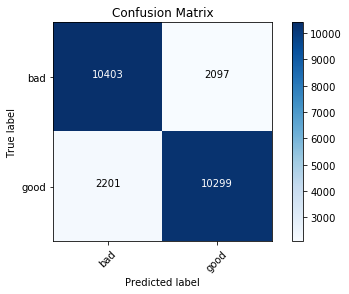

In [17]:
cm_plot_labels = ["bad", "good"]
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## io

In [18]:
"""
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
"""

'\nimport io\n\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, vocab_size):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

In [19]:
"""
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
  """

"\ntry:\n  from google.colab import files\nexcept ImportError:\n  pass\nelse:\n  files.download('vecs.tsv')\n  files.download('meta.tsv')\n  "

In [20]:
"""
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)
"""

'\nsentence = "I really think this is amazing. honest."\nsequence = tokenizer.texts_to_sequences(sentence)\nprint(sequence)\n'